#Importaciones#

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import defaultdict
from skimage.feature import hog, local_binary_pattern
from PIL import Image
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Ruta específica para análisis
path = '/content/drive/MyDrive/dataset2'

# Leer contenido
items = os.listdir(path)

print(f"Contenido de {path}:")
for item in items:
    print(f"- {item}")

Contenido de /content/drive/MyDrive/dataset2:
- Final Training Data
- Vineyards Leaf Disease Detection.v6i.coco


In [ ]:
roboflow_path = '/content/drive/MyDrive/dataset2/Vineyards Leaf Disease Detection.v6i.coco'
kaggle_path = '/content/drive/MyDrive/dataset2/Final Training Data'

print("INICIANDO ANÁLISIS DE DATASETS DE VIÑEDOS")
print("=" * 60)

INICIANDO ANÁLISIS DE DATASETS DE VIÑEDOS


Funciones de Analisis

In [ ]:
def analyze_image_dimensions(image_paths):
    """Analizar dimensiones de imágenes"""
    dimensions = []
    for img_path in image_paths:
        try:
            img = cv2.imread(img_path)
            if img is not None:
                h, w, c = img.shape
                dimensions.append((w, h))
        except:
            continue
    return dimensions

def extract_hog_features(image_path):
    """Extraer características HOG"""
    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            # Redimensionar para consistencia
            img = cv2.resize(img, (128, 128))
            features = hog(img, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), visualize=False)
            return features
    except:
        return None
    return None

def extract_lbp_features(image_path):
    """Extraer características LBP (Local Binary Pattern)"""
    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            # Redimensionar para consistencia
            img = cv2.resize(img, (128, 128))
            # Parámetros LBP
            radius = 3
            n_points = 8 * radius
            lbp = local_binary_pattern(img, n_points, radius, method='uniform')
            # Histograma de LBP
            hist, _ = np.histogram(lbp.ravel(), bins=n_points + 2,
                                 range=(0, n_points + 2), density=True)
            return hist
    except:
        return None
    return None

Analisis Dataset Roboflow (Coco Format)

In [ ]:
print("\n📊 ANÁLISIS DATASET ROBOFLOW")
print("-" * 40)

roboflow_stats = {
    'train': {'images': 0, 'annotations': 0, 'classes': set()},
    'valid': {'images': 0, 'annotations': 0, 'classes': set()},
    'test': {'images': 0, 'annotations': 0, 'classes': set()}
}

roboflow_dimensions = {'train': [], 'valid': [], 'test': []}
roboflow_hog_features = {'train': [], 'valid': [], 'test': []}
roboflow_lbp_features = {'train': [], 'valid': [], 'test': []}

# Analizar cada split (train, valid, test)
for split in ['train', 'valid', 'test']:
    split_path = os.path.join(roboflow_path, split)
    annotation_file = os.path.join(split_path, '_annotations.coco.json')

    if os.path.exists(annotation_file):
        print(f"\n🔍 Analizando {split.upper()}...")

        # Cargar anotaciones COCO
        with open(annotation_file, 'r') as f:
            coco_data = json.load(f)

        # Estadísticas básicas
        images = coco_data.get('images', [])
        annotations = coco_data.get('annotations', [])
        categories = coco_data.get('categories', [])

        roboflow_stats[split]['images'] = len(images)
        roboflow_stats[split]['annotations'] = len(annotations)

        # Clases
        for cat in categories:
            roboflow_stats[split]['classes'].add(cat['name'])

        print(f"  📸 Imágenes: {len(images)}")
        print(f"  🏷️  Anotaciones: {len(annotations)}")
        print(f"  📁 Clases: {len(categories)}")

        # Analizar imágenes
        image_paths = []
        for img_info in images[:50]:  # Limitar para análisis inicial
            img_path = os.path.join(split_path, img_info['file_name'])
            if os.path.exists(img_path):
                image_paths.append(img_path)

        # Dimensiones
        dimensions = analyze_image_dimensions(image_paths)
        roboflow_dimensions[split] = dimensions

        # Características HOG y LBP (muestra pequeña para eficiencia)
        for img_path in image_paths[:10]:
            hog_feat = extract_hog_features(img_path)
            lbp_feat = extract_lbp_features(img_path)

            if hog_feat is not None:
                roboflow_hog_features[split].append(hog_feat)
            if lbp_feat is not None:
                roboflow_lbp_features[split].append(lbp_feat)



📊 ANÁLISIS DATASET ROBOFLOW
----------------------------------------

🔍 Analizando TRAIN...
  📸 Imágenes: 28077
  🏷️  Anotaciones: 28854
  📁 Clases: 6

🔍 Analizando VALID...
  📸 Imágenes: 801
  🏷️  Anotaciones: 824
  📁 Clases: 6

🔍 Analizando TEST...
  📸 Imágenes: 535
  🏷️  Anotaciones: 559
  📁 Clases: 6


Analisis Dataset Kaggle (Folders by Class)



In [ ]:
print("\n\n📊 ANÁLISIS DATASET KAGGLE")
print("-" * 40)

kaggle_stats = {}
kaggle_dimensions = {}
kaggle_hog_features = {}
kaggle_lbp_features = {}

# Clases esperadas
classes = ['Black Rot', 'ESCA', 'Healthy', 'Leaf Blight']

for class_name in classes:
    class_path = os.path.join(kaggle_path, class_name)

    if os.path.exists(class_path):
        print(f"\n🔍 Analizando clase: {class_name}")

        # Obtener todas las imágenes PNG
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith('.png')]

        kaggle_stats[class_name] = len(image_files)
        print(f"  📸 Imágenes: {len(image_files)}")

        # Analizar muestra de imágenes
        sample_images = image_files[:20]  # Muestra para análisis
        image_paths = [os.path.join(class_path, img) for img in sample_images]

        # Dimensiones
        dimensions = analyze_image_dimensions(image_paths)
        kaggle_dimensions[class_name] = dimensions

        # Características HOG y LBP
        hog_features = []
        lbp_features = []



        for img_path in image_paths[:10]:  # Muestra pequeña
            hog_feat = extract_hog_features(img_path)
            lbp_feat = extract_lbp_features(img_path)

            if hog_feat is not None:
                hog_features.append(hog_feat)
            if lbp_feat is not None:
                lbp_features.append(lbp_feat)

        kaggle_hog_features[class_name] = hog_features
        kaggle_lbp_features[class_name] = lbp_features



📊 ANÁLISIS DATASET KAGGLE
----------------------------------------

🔍 Analizando clase: Black Rot
  📸 Imágenes: 1350

🔍 Analizando clase: ESCA
  📸 Imágenes: 1344

🔍 Analizando clase: Healthy
  📸 Imágenes: 1344

🔍 Analizando clase: Leaf Blight
  📸 Imágenes: 1346


Visualizacion de Resultados



 GENERANDO VISUALIZACIONES...


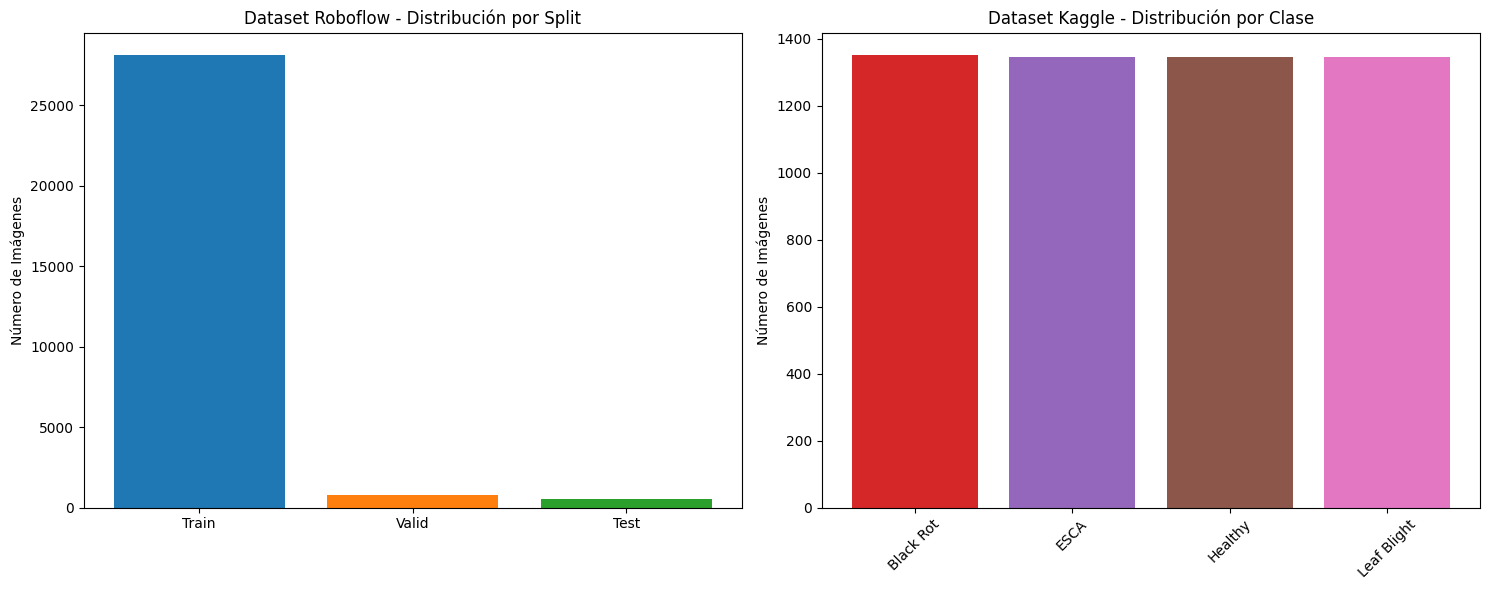


 ANÁLISIS DE DIMENSIONES:
Roboflow TRAIN:
  - Ancho promedio: 224.0px
  - Alto promedio: 224.0px
  - Dimensión más común: (224, 224)
Roboflow VALID:
  - Ancho promedio: 224.0px
  - Alto promedio: 224.0px
  - Dimensión más común: (224, 224)
Roboflow TEST:
  - Ancho promedio: 224.0px
  - Alto promedio: 224.0px
  - Dimensión más común: (224, 224)
Kaggle Black Rot:
  - Ancho promedio: 224.0px
  - Alto promedio: 224.0px
Kaggle ESCA:
  - Ancho promedio: 224.0px
  - Alto promedio: 224.0px
Kaggle Healthy:
  - Ancho promedio: 224.0px
  - Alto promedio: 224.0px
Kaggle Leaf Blight:
  - Ancho promedio: 224.0px
  - Alto promedio: 224.0px


In [ ]:
print("\n\n GENERANDO VISUALIZACIONES...")

# 1. Distribución de imágenes por dataset
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Roboflow distribution
roboflow_counts = [roboflow_stats[split]['images'] for split in ['train', 'valid', 'test']]
axes[0].bar(['Train', 'Valid', 'Test'], roboflow_counts, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0].set_title('Dataset Roboflow - Distribución por Split')
axes[0].set_ylabel('Número de Imágenes')

# Kaggle distribution
kaggle_counts = list(kaggle_stats.values())
kaggle_labels = list(kaggle_stats.keys())
axes[1].bar(kaggle_labels, kaggle_counts, color=['#d62728', '#9467bd', '#8c564b', '#e377c2'])
axes[1].set_title('Dataset Kaggle - Distribución por Clase')
axes[1].set_ylabel('Número de Imágenes')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 2. Análisis de dimensiones
print("\n ANÁLISIS DE DIMENSIONES:")
print("=" * 30)

# Roboflow dimensions
for split in ['train', 'valid', 'test']:
    if roboflow_dimensions[split]:
        widths, heights = zip(*roboflow_dimensions[split])
        print(f"Roboflow {split.upper()}:")
        print(f"  - Ancho promedio: {np.mean(widths):.1f}px")
        print(f"  - Alto promedio: {np.mean(heights):.1f}px")
        print(f"  - Dimensión más común: {max(set(roboflow_dimensions[split]), key=roboflow_dimensions[split].count)}")

# Kaggle dimensions
for class_name in classes:
    if class_name in kaggle_dimensions and kaggle_dimensions[class_name]:
        widths, heights = zip(*kaggle_dimensions[class_name])
        print(f"Kaggle {class_name}:")
        print(f"  - Ancho promedio: {np.mean(widths):.1f}px")
        print(f"  - Alto promedio: {np.mean(heights):.1f}px")

In [ ]:
print("\n\n RESUMEN FINAL DEL ANÁLISIS")
print("=" * 50)

total_roboflow = sum(roboflow_stats[split]['images'] for split in ['train', 'valid', 'test'])
total_kaggle = sum(kaggle_stats.values())

print(f" DATASET ROBOFLOW:")
print(f"  - Total de imágenes: {total_roboflow}")
print(f"  - Formato: JPG")
print(f"  - Estructura: COCO (train/valid/test)")
print(f"  - Clases únicas: {len(set().union(*[roboflow_stats[split]['classes'] for split in ['train', 'valid', 'test']]))}")

print(f"\n DATASET KAGGLE:")
print(f"  - Total de imágenes: {total_kaggle}")
print(f"  - Formato: PNG")
print(f"  - Estructura: Carpetas por clase")
print(f"  - Clases: {len(kaggle_stats)} ({', '.join(kaggle_stats.keys())})")

print(f"\n CARACTERÍSTICAS EXTRAÍDAS:")
print(f"  - HOG: Extraídas para ambos datasets")
print(f"  - LBP: Extraídas para ambos datasets")
print(f"  - Dimensiones: Analizadas para todos los splits y clases")



 RESUMEN FINAL DEL ANÁLISIS
 DATASET ROBOFLOW:
  - Total de imágenes: 29413
  - Formato: JPG
  - Estructura: COCO (train/valid/test)
  - Clases únicas: 6

 DATASET KAGGLE:
  - Total de imágenes: 5384
  - Formato: PNG
  - Estructura: Carpetas por clase
  - Clases: 4 (Black Rot, ESCA, Healthy, Leaf Blight)

 CARACTERÍSTICAS EXTRAÍDAS:
  - HOG: Extraídas para ambos datasets
  - LBP: Extraídas para ambos datasets
  - Dimensiones: Analizadas para todos los splits y clases


Reorganizacion de Datasets

In [ ]:
import os
import json
import shutil
from collections import defaultdict
import cv2

Configuracion de Rutas

In [ ]:
roboflow_original = '/content/drive/MyDrive/dataset2/Vineyards Leaf Disease Detection.v6i.coco'
kaggle_original = '/content/drive/MyDrive/dataset2/Final Training Data'

# Ruta NUEVA para dataset completo
dataset_completo = '/content/drive/MyDrive/dataset2/dataset Completo'

print(f"📂 RUTAS DE TRABAJO:")
print(f"  📖 Roboflow original (solo lectura): {roboflow_original}")
print(f"  📖 Kaggle original (solo lectura): {kaggle_original}")
print(f"  📝 Dataset completo (nuevo): {dataset_completo}")

# Verificar que originales existen
if not os.path.exists(roboflow_original):
    print(f"❌ Error: No se encuentra {roboflow_original}")
    exit()

if not os.path.exists(kaggle_original):
    print(f"❌ Error: No se encuentra {kaggle_original}")
    exit()

# Crear directorio del dataset completo
os.makedirs(dataset_completo, exist_ok=True)
print(f"✅ Creada carpeta: {dataset_completo}")

📂 RUTAS DE TRABAJO:
  📖 Roboflow original (solo lectura): /content/drive/MyDrive/dataset2/Vineyards Leaf Disease Detection.v6i.coco
  📖 Kaggle original (solo lectura): /content/drive/MyDrive/dataset2/Final Training Data
  📝 Dataset completo (nuevo): /content/drive/MyDrive/dataset2/dataset Completo
✅ Creada carpeta: /content/drive/MyDrive/dataset2/dataset Completo


In [ ]:
print("\n📋 PASO 1: Analizando clases en Roboflow original...")

# Diccionario para mapear IDs de categorías a nombres
category_mapping = {}
all_roboflow_classes = set()

# Leer anotaciones ORIGINALES sin modificarlas
for split in ['train', 'valid', 'test']:
    annotation_file = os.path.join(roboflow_original, split, '_annotations.coco.json')

    if os.path.exists(annotation_file):
        with open(annotation_file, 'r') as f:
            coco_data = json.load(f)

        # Extraer categorías
        categories = coco_data.get('categories', [])
        for cat in categories:
            category_mapping[cat['id']] = cat['name']
            all_roboflow_classes.add(cat['name'])

print(f"🏷️ Clases encontradas en Roboflow: {sorted(all_roboflow_classes)}")
print(f"📊 Total de clases Roboflow: {len(all_roboflow_classes)}")


📋 PASO 1: Analizando clases en Roboflow original...
🏷️ Clases encontradas en Roboflow: ['Black_rot', 'Downey_mildew', 'Esca', 'Healthy', 'Leaf_blight', 'Vineyards-leaf-diseases']
📊 Total de clases Roboflow: 6


In [ ]:
print("\n📋 PASO 2: Analizando clases en Kaggle original...")

kaggle_classes = []
if os.path.exists(kaggle_original):
    kaggle_classes = [item for item in os.listdir(kaggle_original)
                     if os.path.isdir(os.path.join(kaggle_original, item))]

print(f"🏷️ Clases encontradas en Kaggle: {sorted(kaggle_classes)}")
print(f"📊 Total de clases Kaggle: {len(kaggle_classes)}")



📋 PASO 2: Analizando clases en Kaggle original...
🏷️ Clases encontradas en Kaggle: ['Black Rot', 'ESCA', 'Healthy', 'Leaf Blight']
📊 Total de clases Kaggle: 4


Crear Estructura en dataset Completo

In [ ]:
print("\n📁 PASO 3: Creando estructura en dataset completo...")

# MAPEO PARA UNIFICAR CLASES DUPLICADAS
class_unification = {
    'Black_rot': 'Black Rot',
    'Black Rot': 'Black Rot',
    'ESCA': 'Esca',
    'Esca': 'Esca',
    'Leaf_blight': 'Leaf Blight',
    'Leaf Blight': 'Leaf Blight',
    'Downey_mildew': 'Downy Mildew',
    'Healthy': 'Healthy',
    'Vineyards-leaf-diseases': 'Mixed_Diseases'
}

# Aplicar unificación a clases de Roboflow
unified_roboflow_classes = set()
for original_class in all_roboflow_classes:
    if original_class in class_unification:
        unified_roboflow_classes.add(class_unification[original_class])
    else:
        unified_roboflow_classes.add(original_class)

# Aplicar unificación a clases de Kaggle
unified_kaggle_classes = set()
for original_class in kaggle_classes:
    if original_class in class_unification:
        unified_kaggle_classes.add(class_unification[original_class])
    else:
        unified_kaggle_classes.add(original_class)

# Obtener todas las clases únicas DESPUÉS de unificación
all_classes = unified_roboflow_classes | unified_kaggle_classes

print(f"🔧 CLASES ANTES DE UNIFICACIÓN:")
print(f"  Roboflow: {sorted(all_roboflow_classes)}")
print(f"  Kaggle: {sorted(kaggle_classes)}")

print(f"\n🔗 CLASES DESPUÉS DE UNIFICACIÓN:")
print(f"  Total únicas: {len(all_classes)}")
print(f"  Clases finales: {sorted(all_classes)}")

# Crear estructura en dataset completo
roboflow_section = os.path.join(dataset_completo, 'Roboflow_Organizado')
kaggle_section = os.path.join(dataset_completo, 'Kaggle_Organizado')
unified_section = os.path.join(dataset_completo, 'Dataset_Unificado')

os.makedirs(roboflow_section, exist_ok=True)
os.makedirs(kaggle_section, exist_ok=True)
os.makedirs(unified_section, exist_ok=True)

# Crear carpetas para cada clase UNIFICADA
for class_name in all_classes:
    os.makedirs(os.path.join(roboflow_section, class_name), exist_ok=True)
    os.makedirs(os.path.join(unified_section, class_name), exist_ok=True)

for class_name in unified_kaggle_classes:
    os.makedirs(os.path.join(kaggle_section, class_name), exist_ok=True)

print(f"✅ Estructura de carpetas creada con clases unificadas")


📁 PASO 3: Creando estructura en dataset completo...
🔧 CLASES ANTES DE UNIFICACIÓN:
  Roboflow: ['Black_rot', 'Downey_mildew', 'Esca', 'Healthy', 'Leaf_blight', 'Vineyards-leaf-diseases']
  Kaggle: ['Black Rot', 'ESCA', 'Healthy', 'Leaf Blight']

🔗 CLASES DESPUÉS DE UNIFICACIÓN:
  Total únicas: 6
  Clases finales: ['Black Rot', 'Downy Mildew', 'Esca', 'Healthy', 'Leaf Blight', 'Mixed_Diseases']
✅ Estructura de carpetas creada con clases unificadas


Copiar y Organizar Roboflow (sin alterar original)

In [ ]:
print("\n🔄 PASO 4: Copiando y organizando Roboflow...")

# Contador de imágenes por clase
roboflow_class_counts = defaultdict(int)

for split in ['train', 'valid', 'test']:
    split_path = os.path.join(roboflow_original, split)
    annotation_file = os.path.join(split_path, '_annotations.coco.json')

    if os.path.exists(annotation_file):
        print(f"\n  🔍 Procesando {split.upper()} (desde original)...")

        with open(annotation_file, 'r') as f:
            coco_data = json.load(f)

        images = coco_data.get('images', [])
        annotations = coco_data.get('annotations', [])

        # Crear mapeo de imagen a categorías UNIFICADAS (IGNORANDO BOUNDING BOXES)
        image_to_categories = defaultdict(set)

        # Solo extraer la clase principal de cada imagen, aplicando unificación
        for ann in annotations:
            image_id = ann['image_id']
            category_id = ann['category_id']
            if category_id in category_mapping:
                original_category = category_mapping[category_id]
                # Aplicar unificación de clases
                unified_category = class_unification.get(original_category, original_category)
                image_to_categories[image_id].add(unified_category)

        # Copiar imágenes COMPLETAS desde ORIGINAL a dataset completo
        processed = 0
        for img_info in images:
            img_id = img_info['id']
            img_filename = img_info['file_name']
            source_path = os.path.join(split_path, img_filename)  # DESDE ORIGINAL

            if os.path.exists(source_path) and img_id in image_to_categories:
                # Si la imagen tiene múltiples clases, usar la más frecuente
                categories = list(image_to_categories[img_id])
                main_category = categories[0] if categories else 'Unknown'

                # Para múltiples detecciones en la misma imagen,
                # tratarla como una sola imagen de clasificación
                if len(categories) > 1:
                    # Priorizar clases de enfermedad sobre "Healthy"
                    disease_classes = [cat for cat in categories if cat.lower() != 'healthy']
                    if disease_classes:
                        main_category = disease_classes[0]

                # Crear nombre único para evitar conflictos
                base_name, ext = os.path.splitext(img_filename)
                new_filename = f"{split}_{base_name}{ext}"

                # Copiar a Roboflow organizado
                roboflow_dest = os.path.join(roboflow_section, main_category, new_filename)
                # Copiar a Dataset unificado
                unified_dest = os.path.join(unified_section, main_category, f"roboflow_{new_filename}")

                try:
                    # Copiar imagen COMPLETA (no recortar bounding boxes)
                    shutil.copy2(source_path, roboflow_dest)
                    shutil.copy2(source_path, unified_dest)
                    roboflow_class_counts[main_category] += 1
                    processed += 1

                    if processed % 1000 == 0:
                        print(f"    📸 Procesadas {processed} imágenes completas...")

                except Exception as e:
                    print(f"    ❌ Error copiando {img_filename}: {e}")

        print(f"  ✅ {split.upper()} completado: {processed} imágenes procesadas")

print(f"\n📊 RESUMEN ROBOFLOW COPIADO (SIN BOUNDING BOXES):")
print("    ⚠️  Imágenes completas copiadas - información de bounding boxes eliminada")
for class_name, count in sorted(roboflow_class_counts.items()):
    print(f"  - {class_name}: {count} imágenes completas JPG")


🔄 PASO 4: Copiando y organizando Roboflow...

  🔍 Procesando TRAIN (desde original)...
    📸 Procesadas 1000 imágenes completas...
    📸 Procesadas 2000 imágenes completas...
    📸 Procesadas 3000 imágenes completas...
    📸 Procesadas 4000 imágenes completas...
    📸 Procesadas 5000 imágenes completas...
    📸 Procesadas 6000 imágenes completas...
    📸 Procesadas 7000 imágenes completas...
    📸 Procesadas 8000 imágenes completas...
    📸 Procesadas 9000 imágenes completas...
    📸 Procesadas 10000 imágenes completas...
    📸 Procesadas 11000 imágenes completas...
    📸 Procesadas 12000 imágenes completas...
    📸 Procesadas 13000 imágenes completas...
    📸 Procesadas 14000 imágenes completas...
    📸 Procesadas 15000 imágenes completas...
    📸 Procesadas 16000 imágenes completas...
    📸 Procesadas 17000 imágenes completas...
    📸 Procesadas 18000 imágenes completas...
    📸 Procesadas 19000 imágenes completas...
    📸 Procesadas 20000 imágenes completas...
    📸 Procesadas 2100